In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from itertools import product
import time


# Ładowanie i transformacja danych

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

def get_subset(dataset, percentage):
    subset_size = int(len(dataset) * percentage)
    return Subset(dataset, list(range(subset_size)))


Using device: cpu


# Definicja modelu

In [4]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, num_channels=1, conv_out_channels=16, kernel_size=3, pool_size=2):
        super(CNNModel, self).__init__
        self.conv1 = nn.Conv2d(num_channels, conv_out_channels, kernel_size=kernel_size, padding="same") # output ma taki sam rozmiar co input
        self.pool = nn.MaxPool2d(kernel_size=pool_size)
        self.flatten = nn.Flatten()
        self.fc = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Funkcja trenująca

In [6]:
def train_model(model, train_loader, test_loader, num_epochs, criterion, optimizer, device):
    model.to(device)
    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                correct += (predicted == targets).sum().item()

        test_losses.append(test_loss / len(test_loader))
        accuracies.append(100 * correct / len(test_loader.dataset))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracies[-1]:.2f}%")

    return train_losses, test_losses, accuracies


In [7]:
def add_gaussian_noise(batch, std_dev):
    noise = torch.randn_like(batch) * std_dev
    noisy_batch = batch + noise
    return noisy_batch


# Eksperymenty

In [18]:
input_size = 28 * 28
num_classes = 10
num_epochs = 20
batch_size = 16
convolution_out_channels_variations = [8, 16, 32, 64 ]
kernel_sizes = [3, 5, 7]
pool_sizes = [2, 3]
gaussian_values = [0.0, 0.1, 0.5, 1.0]

def train_with_params(convolution_out_channels, kernel_size, pool_size, gaussian_value):
    print(f"Running: \n\t conv out channels: {convolution_out_channels}\n\t kernel size: {kernel_size}\n\t pool size: {pool_size}\n\t gaussian value: {gaussian_value}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    model = CNNModel(num_classes=num_classes, conv_out_channels=convolution_out_channels, kernel_size=kernel_size, pool_size=pool_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    start_time = time.time()
    train_losses, test_losses, accuracies = train_model(model, train_loader, test_loader, num_epochs, criterion, optimizer, device)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken : {elapsed_time:.2f} seconds")
    plt.plot(accuracies, label=f"conv out channels: {convolution_out_channels}, kernel size: {kernel_size}, pool size: {pool_size}, gaussian value: {gaussian_value}")


# Wpływ liczby kanałów wyjściowych warstwy konwolucyjnej

Running: 
	 conv out channels: 8
	 kernel size: 3
	 pool size: 2
	 gaussian value: 0.0
Epoch 1/20, Loss: 0.6242, Accuracy: 82.71%
Epoch 2/20, Loss: 0.4529, Accuracy: 83.74%
Epoch 3/20, Loss: 0.4074, Accuracy: 85.30%
Epoch 4/20, Loss: 0.3818, Accuracy: 86.44%
Epoch 5/20, Loss: 0.3665, Accuracy: 85.90%
Epoch 6/20, Loss: 0.3548, Accuracy: 86.12%
Epoch 7/20, Loss: 0.3436, Accuracy: 86.92%
Epoch 8/20, Loss: 0.3356, Accuracy: 86.71%
Epoch 9/20, Loss: 0.3288, Accuracy: 87.48%
Epoch 10/20, Loss: 0.3214, Accuracy: 87.83%
Epoch 11/20, Loss: 0.3142, Accuracy: 87.42%
Epoch 12/20, Loss: 0.3083, Accuracy: 88.13%
Epoch 13/20, Loss: 0.3048, Accuracy: 88.23%
Epoch 14/20, Loss: 0.2985, Accuracy: 87.99%
Epoch 15/20, Loss: 0.2949, Accuracy: 87.95%
Epoch 16/20, Loss: 0.2897, Accuracy: 88.44%
Epoch 17/20, Loss: 0.2865, Accuracy: 88.28%
Epoch 18/20, Loss: 0.2828, Accuracy: 88.76%
Epoch 19/20, Loss: 0.2792, Accuracy: 88.29%
Epoch 20/20, Loss: 0.2763, Accuracy: 88.79%
Time taken : 250.14 seconds
Running: 
	 co

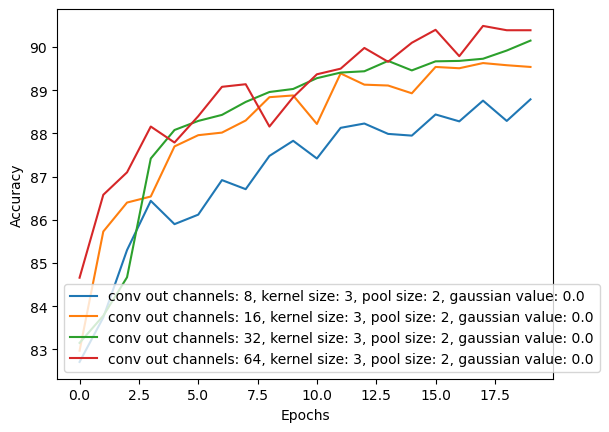

In [19]:
for convolution_out_channels in convolution_out_channels_variations:
    train_with_params(convolution_out_channels, kernel_size=3, pool_size=pool_sizes[0], gaussian_value=gaussian_values[0])

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()
